constructed wavelet basis with 51 params for signal of length 48


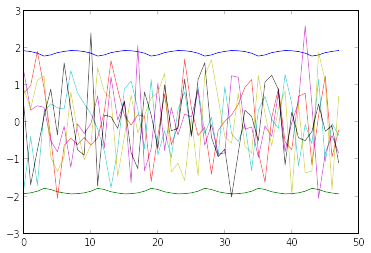

In [70]:
basis = construct_wavelet_basis(4.0, "db3_1_5_12", sort=False)
wvars = np.diag(np.dot(basis.T, basis))
plot(2*np.sqrt(wvars))
plot(-2*np.sqrt(wvars))
gca().set_ylim([-3, 3])

for i in range(5):
    v = np.random.randn(basis.shape[0])
    plot(np.dot(basis.T, v), alpha=0.8)

In [ ]:
# how are we doing this?
# option 1: construct wavelet decomposition of 5hz signal, then cut off levels until we're close to 2Hz
# option 2: construct wavelet decomposition of 2Hz signal, then somehow rescale those wavelets to 5hz

# what I was originally doing:
# do a decomposition of a 2Hz signal, then add layers to get to something I can extract as 5Hz

"""
I'm worried that my basic assumption is false, that wavelets at an arbitrary level don't provide a uniform basis.
Let's think about this a bit. 
First of all it's not clear that uniform variance is the only thing I want.
BUT, uniform variance is equivalent to just having each basis coef be an independent unit vector. 
Then all dot products are ones and all off-diagonals are zeros.
Actually uniformity is just the unit-vector condition, though independence also seems like a good property.

I thought we were supposed to get this by default?
Actually I'm not computing dot products of basis vectors, that's the BB' and I'm computing B'B. 
The basis vectors *are* all basically unit orthogonal except at the edges of the signal, which is fine.

What's the linear algebraic property I'm looking for?

How does this work with Haar wavelets?
Haar wavelets all seem totally uncorrelated, we get unit variance regardless of what level we look at. 

With db2, we have "sums" and "differences" of length 4 at the low level. 
If we disregard the "differences" in Haar, we induce correlations among neighboring signal points, but the 

"""

In [8]:
basis.shape

(22, 86)

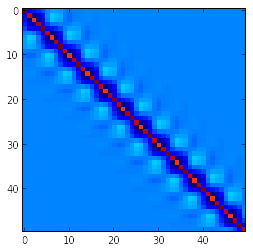

In [35]:
imshow(np.dot(basis.T, basis), interpolation="None")

[17, 17, 28]
(34, 50)


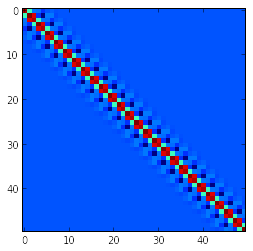

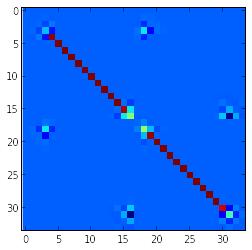

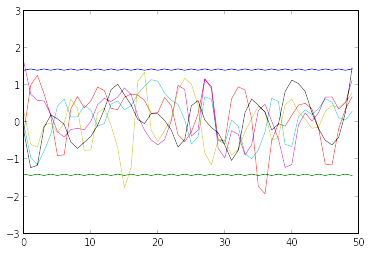

In [93]:
def construct_basis_simple(N, family, pad, level=None, minlevel=None):
    minlevel = minlevel if minlevel is not None else 0
    z = np.zeros((N,))
    cc = pywt.wavedec(z, family, pad, level=level)
    nb = np.sum([len(l) for l in (cc[:-minlevel] if minlevel > 0 else cc)])
    basis = np.zeros((nb, N))
    k=0
    print [len(l) for l in cc]
    for i in range(len(cc)-minlevel):
        for j in range(len(cc[i])):
            cc[i][j] = 1
            basis[k+j, :] = pywt.waverec(cc, family, pad)
            cc[i][j] = 0
        k += len(cc[i])
    return basis

basis = construct_basis_simple(50, "db4", "zpd", minlevel=1)
print basis.shape

imshow(np.dot(basis.T, basis), interpolation="None")
figure()
imshow(np.dot(basis, basis.T), interpolation="None")
figure()
wvars = np.diag(np.dot(basis.T, basis))
plot(2*np.sqrt(wvars))
plot(-2*np.sqrt(wvars))
gca().set_ylim([-3, 3])

for i in range(5):
    v = np.random.randn(basis.shape[0])
    plot(np.dot(basis.T, v), alpha=0.8)

In [102]:
from sigvisa.models.wiggles.wavelets import construct_implicit_basis_simple

start_times, end_times, identities, prototypes, N = construct_implicit_basis_simple(50, "db4", "zpd")
truncated = np.array(identities) < 2
start_times, end_times, identities = np.array(start_times)[truncated], np.array(end_times)[truncated], np.array(identities)[truncated]

In [10]:
import autograd.numpy as np
from autograd import grad

def implicit_to_explicit(start_times, end_times, identities, prototypes, N):
    m = len(start_times)
    basis = []
    for i in range(m):
        st = max(start_times[i], 0)
        et = min(end_times[i], N)
        npts= et-st
        offset = st-start_times[i]
        
        # this is kinda awkward but makes autograd happy
        thisbasis = np.concatenate([np.zeros((st,)), prototypes[identities[i]][offset:offset+npts], np.zeros((N-et))])
        
        basis.append(thisbasis)
    basis = np.array(basis)
    return basis

def optimize_for_uniform_variance(start_times, end_times, identities, prototypes, N, target_var=1.0):
    
    n_prototypes = len(prototypes)
    plens = [len(p) for p in prototypes]
    pstarts = np.concatenate([np.array((0,)), np.cumsum(plens)[:-1]])
    def unflatten(x):
        scale = x[-1]
        prototypes = [x[pstarts[i]:pstarts[i]+plens[i]]*scale for i in range(n_prototypes)]
        return prototypes
    
    def flatten(prototypes, scale):
        return np.concatenate([np.concatenate(prototypes), np.array((scale,))])
    
    x0 = flatten(prototypes, 1.0)
    
    def obj(x):
        prototypes = unflatten(x)
        basis = implicit_to_explicit(start_times, end_times, identities, prototypes, N)
    
        m = np.dot(basis.T, basis)
        v = np.diag(m)
        
        v1 = m[2, 0:4]
        v2 = m[3, 1:5]
        v3 = m[4, 2:6]
        v4 = m[5, 3:7]
        
        sqr = np.sum((v-1.0)**2)+ 0.1*np.sum((x[:-1]-x0[:-1])**2) + np.sum((v1-v2)**2)+ np.sum((v4-v3)**2)
        return sqr
    
    gradobj = grad(obj)
    r = scipy.optimize.minimize(lambda x : (obj(x), gradobj(x)), x0, jac=True)
    #print r
    
    print obj(x0)
    print gradobj(x0)
    
    prototypes_new = unflatten(r.x)
    
    return prototypes_new



12.9134010958
[ -1.49406108e+00  -3.55156845e+00  -8.67837163e+00  -1.24728212e+01
  -1.35429275e+01  -1.06041024e+01  -6.49519884e+00  -1.03682536e-01
   3.98293395e+00   2.90659341e+00   2.08710752e+00  -3.04273604e-01
  -1.51365846e+00  -4.70178210e-01  -1.37996741e-01   1.15758005e-01
   2.84749972e-01  -3.54227404e-03  -8.09424586e-02   1.26275403e-02
   7.87734413e-03  -2.11632495e-03   6.87269547e-02   1.63372493e-01
   4.00375072e-01   5.87572418e-01   2.34755341e-01  -4.35058863e-01
  -1.96014664e+00  -3.28249732e+00  -2.40183800e+00   2.02126136e-01
   5.79544003e+00   1.11465966e+01   4.28525693e+00  -1.12537180e+01
  -1.29077521e+01   4.06442708e+00   7.15752911e+00  -3.36887151e-01
  -1.74579352e+00   2.73342031e-01   1.71246250e-01  -4.60069670e-02
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
  -4.83463956e+01]
[ 0.99997254  1.0000239   0.99996948  1.000028    0.99997254  1.000023

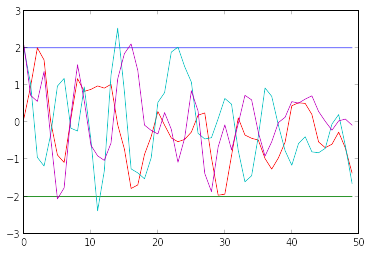

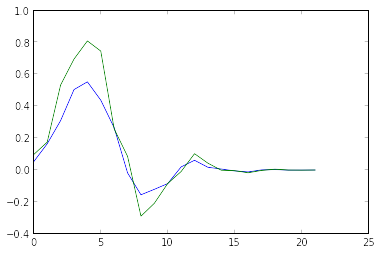

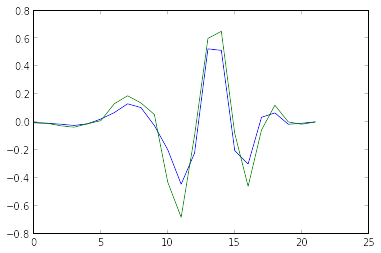

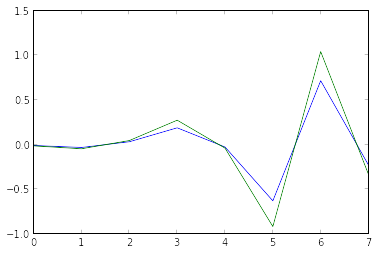

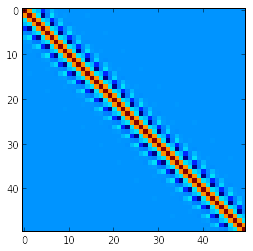

In [191]:
pnew = optimize_for_uniform_variance(start_times, end_times, identities, prototypes, N, target_var=1.0)
basis = implicit_to_explicit(start_times, end_times, identities, pnew, N)
v = np.diag(np.dot(basis.T, basis))
print v
plot(2*np.sqrt(v))
plot(-2*np.sqrt(v))
for i in range(3):
    w = np.random.randn(basis.shape[0])
    plot(np.dot(basis.T, w))

figure()
plot(prototypes[0])
plot(pnew[0])
figure()
plot(prototypes[1])
plot(pnew[1])
figure()
plot(prototypes[2])
plot(pnew[2])
figure()

imshow(np.dot(basis.T, basis), interpolation="None")

In [ ]:
from sigvisa.models.wiggles.wavelets import implicit_basis_to_C_format
sta, eta, ita, M, N = implicit_basis_to_C_format((start_times, end_times, identities, pnew, N))

In [6]:
from sigvisa.models.wiggles.uniform_variance_wavelets import uvar_wavelet_basis, implicit_to_explicit

In [8]:
basis, target_std = uvar_wavelet_basis(5.0, "db4uvars_2.0_3_30_2.0")
sta, eta, ida, M, N = basis

[ 4.00030449  3.99782131  4.0002995   4.00156643  4.00176707  3.99889527
  4.00098175  3.99885688  3.99951291  3.9999352   4.00034091  3.99988048
  3.99946977  4.00025144  4.00039028  3.99996758  3.99945655  4.0002746
  4.0003238   3.99976527  3.99950263  4.00021357  4.00036229  4.00005435
  3.99951284  3.99993522  4.00034093  3.99988047  3.99946974  4.00025143
  4.00045501  3.99996219  4.00030449  3.99782131  4.0002995   4.00156643
  4.00176707  3.99889527  4.00098175  3.99885688  3.99951291  3.9999352
  4.00034091  3.99988048  3.99946977  4.00025144  4.00039028  3.99996758
  3.99945655  4.0002746   4.0003238   3.99976527  3.99950263  4.00021357
  4.00036229  4.00005435  3.99951284  3.99993522  4.00034093  3.99988047
  3.99946974  4.00025143  4.00045501  3.99996219  4.00030449  3.99782131
  4.0002995   4.00156643  4.00176707  3.99889527  4.00098175  3.99885688
  3.99951291  3.9999352   4.00034091  3.99988048  3.99946977  4.00025144
  4.00039028  3.99996758  3.99945655  4.0002746   4.0

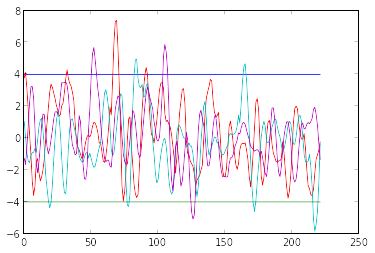

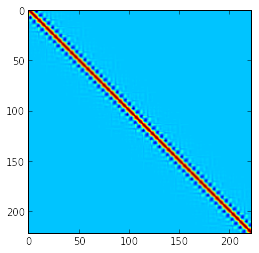

In [9]:
ptypes = [np.asarray(m[np.isfinite(m)]).flatten() for m in M]
basis = implicit_to_explicit(sta, eta, ida, ptypes, N )


v = np.diag(np.dot(basis.T, basis))
print v
plot(2*np.sqrt(v))
plot(-2*np.sqrt(v))
for i in range(3):
    w = np.random.randn(basis.shape[0])
    plot(np.dot(basis.T, w))
    
figure()
imshow(np.dot(basis.T, basis))

In [23]:
print ptypes

[matrix([[  2.46749041e-03,   8.25089600e-03,   1.68037111e-02,
           2.48173349e-02,   3.34924666e-02,   4.74881374e-02,
           6.48242766e-02,   7.61961805e-02,   8.75060747e-02,
           1.10139278e-01,   1.36414540e-01,   1.43503808e-01,
           1.57111154e-01,   1.88160116e-01,   2.22165991e-01,
           2.33658630e-01,   2.44003554e-01,   2.87562562e-01,
           3.38429370e-01,   3.32044439e-01,   3.39471978e-01,
           3.91459552e-01,   4.42262507e-01,   4.39755968e-01,
           4.45699405e-01,   5.09309091e-01,   5.80313267e-01,
           5.69671493e-01,   5.81797416e-01,   6.50039965e-01,
           7.21682709e-01,   7.16981491e-01,   7.05627543e-01,
           7.81182474e-01,   8.61877934e-01,   7.89291021e-01,
           7.53464880e-01,   8.11410292e-01,   8.51893936e-01,
           7.83533007e-01,   7.34410784e-01,   7.76052421e-01,
           8.15880874e-01,   7.38267636e-01,   6.90234830e-01,
           6.99993732e-01,   7.01572399e-01,   6.24153